 Region-Wise Patch Loader and Preprocessor

In [4]:
import os
import numpy as np
import random
from sklearn.model_selection import train_test_split

# Directories
PATCHES_DIR = r"data\patches with padding"

# Hyperparameters
TEST_SPLIT = 0.2

# Function to process region in batches
def process_region(region_name, X_train_list, Y_train_list, X_test_list, Y_test_list):
    region_dir = os.path.join(PATCHES_DIR, region_name)

    for file in os.listdir(region_dir):
        if file.endswith(".npy") and "label" not in file:
            patch = np.load(os.path.join(region_dir, file)).astype(np.float32)  # Use float32
            label_file = file.replace(".npy", "_label.npy")
            label = np.load(os.path.join(region_dir, label_file)).astype(np.float32)

            # Normalize patch data
            patch = patch[..., :5] / np.max(patch[..., :5], initial=1, keepdims=True)  # Normalize

            # Split into train/test
            if random.random() < TEST_SPLIT:
                X_test_list.append(patch)
                Y_test_list.append(label)
            else:
                X_train_list.append(patch)
                Y_train_list.append(label)

# Main function to process all regions without memory overflow
def prepare_train_test_data():
    X_train, Y_train = [], []
    X_test, Y_test = [], []

    for region in os.listdir(PATCHES_DIR):
        print(f"Processing region: {region}...")
        process_region(region, X_train, Y_train, X_test, Y_test)

    # Convert to numpy arrays
    X_train = np.array(X_train)
    Y_train = np.array(Y_train)
    X_test = np.array(X_test)
    Y_test = np.array(Y_test)

    print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

    return X_train, X_test, Y_train, Y_test

if __name__ == "__main__":
    X_train, X_test, Y_train, Y_test = prepare_train_test_data()

Processing region: BRB...
Processing region: CHC...
Processing region: CQC...
Processing region: CYP...
Processing region: DEU...
Processing region: EIU...
Processing region: GUP...
Processing region: MGD...
Processing region: MUL...
Processing region: NET...
Processing region: NWH...
Processing region: SEQ...
Processing region: WET...
Training set: (150788, 32, 32, 5), Test set: (37912, 32, 32, 5)


In [1]:
import os
import numpy as np
import random
from sklearn.model_selection import train_test_split

# Directories
PATCHES_DIR = r"data\patches with padding_v02"
PROCESSED_DIR = r"data\processed_v02"
os.makedirs(PROCESSED_DIR, exist_ok=True)

# Hyperparameters
TEST_SPLIT = 0.2

# Function to process region in batches
def process_region(region_name, X_train_list, Y_train_list, X_test_list, Y_test_list):
    region_dir = os.path.join(PATCHES_DIR, region_name)

    for file in os.listdir(region_dir):
        if file.endswith(".npy") and "label" not in file:
            patch = np.load(os.path.join(region_dir, file)).astype(np.float32)  # Use float32
            label_file = file.replace(".npy", "_label.npy")
            label = np.load(os.path.join(region_dir, label_file)).astype(np.float32)

            # Normalize patch data
            patch = patch[..., :5] / np.max(patch[..., :5], initial=1, keepdims=True)  # Normalize

            # Split into train/test
            if random.random() < TEST_SPLIT:
                X_test_list.append(patch)
                Y_test_list.append(label)
            else:
                X_train_list.append(patch)
                Y_train_list.append(label)

# Main function to process all regions without memory overflow
def prepare_train_test_data():
    X_train, Y_train = [], []
    X_test, Y_test = [], []

    for region in os.listdir(PATCHES_DIR):
        print(f"Processing region: {region}...")
        process_region(region, X_train, Y_train, X_test, Y_test)

    # Convert to numpy arrays
    X_train = np.array(X_train)
    Y_train = np.array(Y_train)
    X_test = np.array(X_test)
    Y_test = np.array(Y_test)

    # Save preprocessed data
    np.save(os.path.join(PROCESSED_DIR, "X_train.npy"), X_train)
    np.save(os.path.join(PROCESSED_DIR, "Y_train.npy"), Y_train)
    np.save(os.path.join(PROCESSED_DIR, "X_test.npy"), X_test)
    np.save(os.path.join(PROCESSED_DIR, "Y_test.npy"), Y_test)

    print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

    return X_train, X_test, Y_train, Y_test

if __name__ == "__main__":
    X_train, X_test, Y_train, Y_test = prepare_train_test_data()

Processing region: BRB...
Processing region: CHC...
Processing region: CQC...
Processing region: CYP...
Processing region: DEU...
Processing region: EIU...
Processing region: GUP...
Processing region: MGD...
Processing region: MUL...
Processing region: NET...
Processing region: NWH...
Processing region: SEQ...
Processing region: WET...
Training set: (150918, 32, 32, 5), Test set: (37782, 32, 32, 5)


In [6]:
import numpy as np

DATA_DIR = r"data\processed_v02"
Y_train = np.load(os.path.join(DATA_DIR, "Y_train.npy"))
Y_test = np.load(os.path.join(DATA_DIR, "Y_test.npy"))

print("Training Labels:", np.unique(Y_train))
print("Testing Labels:", np.unique(Y_test))
print("Any NaN in Labels?", np.isnan(Y_train).any() or np.isnan(Y_test).any())


Training Labels: [0. 1.]
Testing Labels: [0. 1.]
Any NaN in Labels? False


In [7]:
X_train = np.load(os.path.join(DATA_DIR, "X_train.npy"))
print("Any NaN in X_train?", np.isnan(X_train).any())
print("Any completely zero patches?", np.all(X_train == 0, axis=(1,2,3)).sum())


Any NaN in X_train? False
Any completely zero patches? 37374


CNN Model Training

In [5]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Directories
DATA_DIR = r"data\processed_v02"
MODEL_SAVE_PATH = r"model\v02\cnn_model.h5"

# Load preprocessed data
def load_data():
    X_train = np.load("data\processed\X_train.npy")
    Y_train = np.load("data\processed\Y_train.npy")
    X_test = np.load("data\processed\X_test.npy")
    Y_test = np.load("data\processed\Y_test.npy")
    return X_train, Y_train, X_test, Y_test

# Building the CNN model
def build_cnn_model(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Flatten())

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Training the CNN model
def train_cnn():
    X_train, Y_train, X_test, Y_test = load_data()

    model = build_cnn_model(X_train.shape[1:])

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    checkpoint = ModelCheckpoint(MODEL_SAVE_PATH, monitor='val_loss', save_best_only=True)

    history = model.fit(
        X_train, Y_train,
        validation_data=(X_test, Y_test),
        epochs=30,
        batch_size=64,
        callbacks=[early_stopping, checkpoint],
        verbose=1
    )

    # Save final model
    model.save(MODEL_SAVE_PATH)
    print("Model training completed and saved.")

if __name__ == "__main__":
    train_cnn()


c:\Users\Jspch\OneDrive\Desktop\ConDrought Implementation\Model Development - CDv05\tf-env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 172s 72ms/step - accuracy: 0.6133 - loss: nan - val_accuracy: 0.6181 - val_loss: nan
Epoch 2/30
2339/2363 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.6128 - loss: nan

KeyboardInterrupt: 

In [9]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Directories
DATA_DIR = r"data\processed_v02"
MODEL_SAVE_PATH = r"model\v02\cnn_model.h5"

# Load preprocessed data
def load_data():
    X_train = np.load(os.path.join(DATA_DIR, "X_train.npy"))
    Y_train = np.load(os.path.join(DATA_DIR, "Y_train.npy"))
    X_test = np.load(os.path.join(DATA_DIR, "X_test.npy"))
    Y_test = np.load(os.path.join(DATA_DIR, "Y_test.npy"))

    # Ensure normalization
    X_train = np.clip(X_train, 0, 1)
    X_test = np.clip(X_test, 0, 1)

    print("Data loaded and normalized.")
    print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")
    return X_train, Y_train, X_test, Y_test

# Building the CNN model with LeakyReLU and Gradient Clipping
def build_cnn_model(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=input_shape))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    model.add(Flatten())

    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    # Optimizer with Gradient Clipping
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Training the CNN model
def train_cnn():
    X_train, Y_train, X_test, Y_test = load_data()

    model = build_cnn_model(X_train.shape[1:])

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    checkpoint = ModelCheckpoint(MODEL_SAVE_PATH, monitor='val_loss', save_best_only=True)

    history = model.fit(
        X_train, Y_train,
        validation_data=(X_test, Y_test),
        epochs=30,
        batch_size=64,
        callbacks=[early_stopping, checkpoint],
        verbose=1
    )

    # Save final model
    model.save(MODEL_SAVE_PATH)
    print("Model training completed and saved.")

if __name__ == "__main__":
    train_cnn()

Data loaded and normalized.
Training set: (150918, 32, 32, 5), Test set: (37782, 32, 32, 5)


c:\Users\Jspch\OneDrive\Desktop\ConDrought Implementation\Model Development - CDv05\tf-env\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/30
2359/2359 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9614 - loss: 0.1037

MemoryError: Unable to allocate 738. MiB for an array with shape (37782, 32, 32, 5) and data type float32

In [8]:
import numpy as np
import os

DATA_DIR = r"data\\processed_v02"

# Load Data
X_train = np.load(os.path.join(DATA_DIR, "X_train.npy"))
Y_train = np.load(os.path.join(DATA_DIR, "Y_train.npy"))
X_test = np.load(os.path.join(DATA_DIR, "X_test.npy"))
Y_test = np.load(os.path.join(DATA_DIR, "Y_test.npy"))

# Check Shapes
print("Training Data Shape:", X_train.shape, Y_train.shape)
print("Testing Data Shape:", X_test.shape, Y_test.shape)

# Check for NaNs in Data
print("\nChecking NaNs in Data...")
print("NaNs in X_train:", np.isnan(X_train).sum())
print("NaNs in X_test:", np.isnan(X_test).sum())
print("NaNs in Y_train:", np.isnan(Y_train).sum())
print("NaNs in Y_test:", np.isnan(Y_test).sum())

# Check Label Values (Y should only be 0 or 1)
print("\nUnique Values in Labels (Y_train):", np.unique(Y_train))
print("Unique Values in Labels (Y_test):", np.unique(Y_test))

# Check Data Value Ranges
print("\nData Range (X_train):", X_train.min(), X_train.max())
print("Data Range (X_test):", X_test.min(), X_test.max())


Training Data Shape: (150918, 32, 32, 5) (150918,)
Testing Data Shape: (37782, 32, 32, 5) (37782,)

Checking NaNs in Data...
NaNs in X_train: 0
NaNs in X_test: 0
NaNs in Y_train: 0
NaNs in Y_test: 0

Unique Values in Labels (Y_train): [0. 1.]
Unique Values in Labels (Y_test): [0. 1.]

Data Range (X_train): -0.15568307 1.0
Data Range (X_test): -0.1512494 1.0


Data loaded and normalized.
Training set: (150918, 32, 32, 5), Test set: (37782, 32, 32, 5)


c:\Users\Jspch\OneDrive\Desktop\ConDrought Implementation\Model Development - CDv05\tf-env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Jspch\OneDrive\Desktop\ConDrought Implementation\Model Development - CDv05\tf-env\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/30
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9565 - loss: 0.1305

c:\Users\Jspch\OneDrive\Desktop\ConDrought Implementation\Model Development - CDv05\tf-env\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


2358/2358 ━━━━━━━━━━━━━━━━━━━━ 177s 74ms/step - accuracy: 0.9566 - loss: 0.1305 - val_accuracy: 0.9750 - val_loss: 0.0668
Epoch 2/30
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 165s 70ms/step - accuracy: 0.9700 - loss: 0.0917 - val_accuracy: 0.9750 - val_loss: 0.0669
Epoch 3/30
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 159s 68ms/step - accuracy: 0.9704 - loss: 0.0862 - val_accuracy: 0.9750 - val_loss: 0.0672
Epoch 4/30
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9705 - loss: 0.0794

2358/2358 ━━━━━━━━━━━━━━━━━━━━ 161s 68ms/step - accuracy: 0.9705 - loss: 0.0794 - val_accuracy: 0.9750 - val_loss: 0.0660
Epoch 5/30
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9713 - loss: 0.0774

2358/2358 ━━━━━━━━━━━━━━━━━━━━ 157s 66ms/step - accuracy: 0.9713 - loss: 0.0774 - val_accuracy: 0.9750 - val_loss: 0.0598
Epoch 6/30
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 158s 67ms/step - accuracy: 0.9713 - loss: 0.0751 - val_accuracy: 0.9750 - val_loss: 0.0600
Epoch 7/30
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 157s 66ms/step - accuracy: 0.9713 - loss: 0.0738 - val_accuracy: 0.9750 - val_loss: 0.0608
Epoch 8/30
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9715 - loss: 0.0719

2358/2358 ━━━━━━━━━━━━━━━━━━━━ 158s 67ms/step - accuracy: 0.9715 - loss: 0.0719 - val_accuracy: 0.9750 - val_loss: 0.0593
Epoch 9/30
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9715 - loss: 0.0706

2358/2358 ━━━━━━━━━━━━━━━━━━━━ 160s 68ms/step - accuracy: 0.9715 - loss: 0.0706 - val_accuracy: 0.9750 - val_loss: 0.0578
Epoch 10/30
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 157s 66ms/step - accuracy: 0.9719 - loss: 0.0686 - val_accuracy: 0.9750 - val_loss: 0.0629
Epoch 11/30
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 155s 66ms/step - accuracy: 0.9726 - loss: 0.0684 - val_accuracy: 0.9750 - val_loss: 0.0615
Epoch 12/30
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 155s 66ms/step - accuracy: 0.9724 - loss: 0.0676 - val_accuracy: 0.9752 - val_loss: 0.0591
Epoch 13/30
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 160s 68ms/step - accuracy: 0.9728 - loss: 0.0659 - val_accuracy: 0.9753 - val_loss: 0.0585
Epoch 14/30
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 159s 67ms/step - accuracy: 0.9725 - loss: 0.0653 - val_accuracy: 0.9752 - val_loss: 0.0621


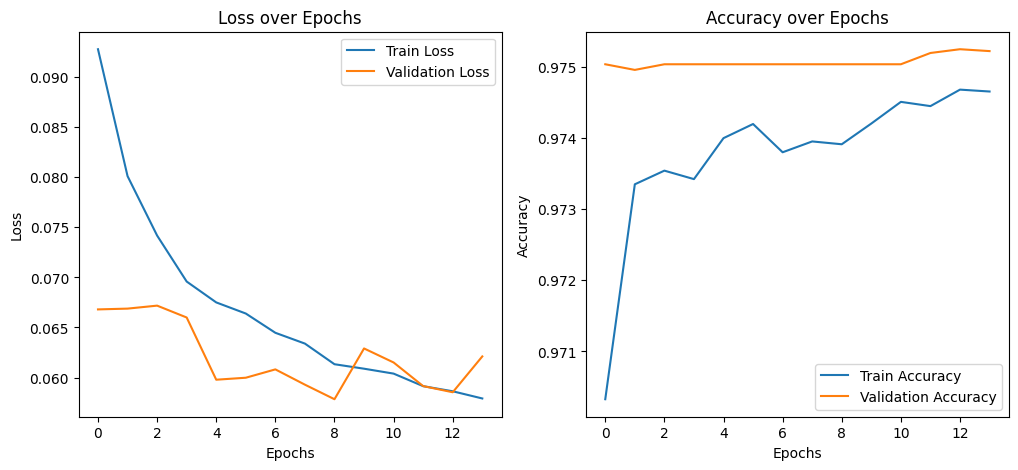

Model training completed and saved.


In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Directories
DATA_DIR = r"data\processed_v02"
MODEL_SAVE_PATH = r"model\v02\cnn_model.h5"

# Data Generator (Efficient Memory Use)
def data_generator(X, Y, batch_size=64):
    while True:
        for start in range(0, len(X), batch_size):
            end = min(start + batch_size, len(X))
            yield X[start:end], Y[start:end]

# Load preprocessed data
def load_data():
    X_train = np.load(os.path.join(DATA_DIR, "X_train.npy"))
    Y_train = np.load(os.path.join(DATA_DIR, "Y_train.npy"))
    X_test = np.load(os.path.join(DATA_DIR, "X_test.npy"))
    Y_test = np.load(os.path.join(DATA_DIR, "Y_test.npy"))

    # Ensure normalization
    X_train = np.clip(X_train, 0, 1)
    X_test = np.clip(X_test, 0, 1)

    print("Data loaded and normalized.")
    print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")
    return X_train, Y_train, X_test, Y_test

# Building the CNN model with LeakyReLU and Gradient Clipping
def build_cnn_model(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=input_shape))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    model.add(Flatten())

    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.5))

    model.add(Dense(1, activation='sigmoid'))

    # Optimizer with Gradient Clipping and Weight Decay
    optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-4, clipnorm=1.0, weight_decay=1e-5)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Training with Real-Time Visualization
def train_cnn():
    X_train, Y_train, X_test, Y_test = load_data()

    model = build_cnn_model(X_train.shape[1:])

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    checkpoint = ModelCheckpoint(MODEL_SAVE_PATH, monitor='val_loss', save_best_only=True)

    # Training with generator
    history = model.fit(
        data_generator(X_train, Y_train),
        validation_data=(X_test, Y_test),
        steps_per_epoch=len(X_train) // 64,
        validation_steps=len(X_test) // 64,
        epochs=30,
        callbacks=[early_stopping, checkpoint],
        verbose=1
    )

    # Save final model
    model.save(MODEL_SAVE_PATH)

    # Real-time Visualization
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

    print("Model training completed and saved.")

if __name__ == "__main__":
    train_cnn()


CNN + LSTM Training

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU, LSTM, TimeDistributed, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# Directories
DATA_DIR = r"data\processed_v02"
MODEL_SAVE_PATH = r"model\cnn_lstm\cnn_lstm_model.h5"

# Load preprocessed data
def load_data():
    X_train = np.load(os.path.join(DATA_DIR, "X_train.npy"))
    Y_train = np.load(os.path.join(DATA_DIR, "Y_train.npy"))
    X_test = np.load(os.path.join(DATA_DIR, "X_test.npy"))
    Y_test = np.load(os.path.join(DATA_DIR, "Y_test.npy"))

    # Ensure normalization
    X_train = np.clip(X_train, 0, 1)
    X_test = np.clip(X_test, 0, 1)

    print("Data loaded and normalized.")
    print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")
    return X_train, Y_train, X_test, Y_test

# Build the CNN + LSTM Model
def build_cnn_lstm_model(input_shape, time_steps=10):
    # CNN Feature Extractor
    cnn_input = Input(shape=(input_shape[1], input_shape[2], input_shape[3]))
    x = Conv2D(32, (3, 3), activation='relu')(cnn_input)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    cnn_model = Model(inputs=cnn_input, outputs=x)

    # LSTM Model
    lstm_input = Input(shape=(time_steps, input_shape[1], input_shape[2], input_shape[3]))
    x = TimeDistributed(cnn_model)(lstm_input)
    x = LSTM(64, return_sequences=False)(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=lstm_input, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Training the CNN + LSTM Model
def train_cnn_lstm():
    X_train, Y_train, X_test, Y_test = load_data()

    # Reshape data for LSTM (time_steps, patches, 32, 32, 5)
    time_steps = 10
    X_train = X_train.reshape((-1, time_steps, 32, 32, 5))
    Y_train = Y_train[::time_steps]

    X_test = X_test.reshape((-1, time_steps, 32, 32, 5))
    Y_test = Y_test[::time_steps]

    print(f"Reshaped Training Data: {X_train.shape}, Testing Data: {X_test.shape}")

    model = build_cnn_lstm_model(X_train.shape[2:])

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    checkpoint = ModelCheckpoint(MODEL_SAVE_PATH, monitor='val_loss', save_best_only=True)

    history = model.fit(
        X_train, Y_train,
        validation_data=(X_test, Y_test),
        epochs=30,
        batch_size=64,
        callbacks=[early_stopping, checkpoint],
        verbose=1
    )

    # Save final model
    model.save(MODEL_SAVE_PATH)

    # Training Visualization
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

if __name__ == "__main__":
    train_cnn_lstm()


Data loaded and normalized.
Training set: (150918, 32, 32, 5), Test set: (37782, 32, 32, 5)


ValueError: cannot reshape array of size 772700160 into shape (10,32,32,5)